In [ ]:
import zipfile
import os

zip_path = r"/content/FINAL_DATASET.zip"
extract_to = "/content/main"

if zipfile.is_zipfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")
else:
    print("The file is not a valid zip file.")

Extraction complete.


In [3]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Set up directories
train_dir = "/content/main/FINAL_DATASET/train"
val_dir = "/content/main/FINAL_DATASET/val"
img_size = (150, 150)
batch_size = 32

In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [6]:
# Check class distribution
print("Training classes:", train_gen.class_indices)
print("Training samples per class:", np.bincount(train_gen.classes))
print("Validation samples per class:", np.bincount(val_gen.classes))

# Calculate class weights if imbalanced
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Training classes: {'fractured': 0, 'not fractured': 1}
Training samples per class: [4480 4383]
Validation samples per class: [360 240]
Class weights: {0: np.float64(0.9891741071428571), 1: np.float64(1.0110654802646588)}


In [7]:
# Build improved model with dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Callbacks
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [10]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weight_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5322 - loss: 0.7967
Epoch 1: val_loss improved from inf to 0.66901, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.5323 - loss: 0.7964 - val_accuracy: 0.5617 - val_loss: 0.6690
Epoch 2/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5692 - loss: 0.6780
Epoch 2: val_loss improved from 0.66901 to 0.64013, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 210ms/step - accuracy: 0.5692 - loss: 0.6780 - val_accuracy: 0.5850 - val_loss: 0.6401
Epoch 3/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6024 - loss: 0.6586
Epoch 3: val_loss did not improve from 0.64013
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 208ms/step - accuracy: 0.6024 - loss: 0.6586 - val_accuracy: 0.6083 - val_loss: 0.6572
Epoch 4/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5980 - loss: 0.6555
Epoch 4: val_loss did not improve from 0.64013
277/277 ━━━━━━━━━━━━━━━━━━━━ 57s 206ms/step - accuracy: 0.5980 - loss: 0.6555 - val_accuracy: 0.6683 - val_loss: 0.6556
Epoch 5/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5879 - loss: 0.6564
Epoch 5: val_loss improved from 0.64013 to 0.63202, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 59s 213ms/step - accuracy: 0.5879 - loss: 0.6564 - val_accuracy: 0.6550 - val_loss: 0.6320
Epoch 6/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6094 - loss: 0.6506
Epoch 6: val_loss did not improve from 0.63202
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 208ms/step - accuracy: 0.6094 - loss: 0.6506 - val_accuracy: 0.5767 - val_loss: 0.6534
Epoch 7/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6026 - loss: 0.6493
Epoch 7: val_loss did not improve from 0.63202
277/277 ━━━━━━━━━━━━━━━━━━━━ 57s 205ms/step - accuracy: 0.6026 - loss: 0.6493 - val_accuracy: 0.5133 - val_loss: 0.7109
Epoch 8/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6322 - loss: 0.6329
Epoch 8: val_loss did not improve from 0.63202
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 207ms/step - accuracy: 0.6322 - loss: 0.6329 - val_accuracy: 0.5550 - val_loss: 0.6792
Epoch 9/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6447 - loss: 0.6140
Epoch 9: val_loss did not i

277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 210ms/step - accuracy: 0.6591 - loss: 0.6091 - val_accuracy: 0.6800 - val_loss: 0.6300
Epoch 11/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6681 - loss: 0.5839
Epoch 11: val_loss improved from 0.63004 to 0.62598, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 209ms/step - accuracy: 0.6681 - loss: 0.5838 - val_accuracy: 0.6267 - val_loss: 0.6260
Epoch 12/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7063 - loss: 0.5520
Epoch 12: val_loss did not improve from 0.62598
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 208ms/step - accuracy: 0.7063 - loss: 0.5520 - val_accuracy: 0.5517 - val_loss: 0.6504
Epoch 13/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.7268 - loss: 0.5265
Epoch 13: val_loss did not improve from 0.62598
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 209ms/step - accuracy: 0.7268 - loss: 0.5265 - val_accuracy: 0.4617 - val_loss: 0.8779
Epoch 14/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7489 - loss: 0.5041
Epoch 14: val_loss improved from 0.62598 to 0.58646, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 210ms/step - accuracy: 0.7489 - loss: 0.5041 - val_accuracy: 0.6167 - val_loss: 0.5865
Epoch 15/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7559 - loss: 0.4880
Epoch 15: val_loss improved from 0.58646 to 0.57327, saving model to best_model.h5


277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 208ms/step - accuracy: 0.7559 - loss: 0.4880 - val_accuracy: 0.6767 - val_loss: 0.5733
Epoch 16/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7679 - loss: 0.4721
Epoch 16: val_loss did not improve from 0.57327
277/277 ━━━━━━━━━━━━━━━━━━━━ 57s 207ms/step - accuracy: 0.7679 - loss: 0.4721 - val_accuracy: 0.5450 - val_loss: 0.7110
Epoch 17/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7746 - loss: 0.4675
Epoch 17: val_loss did not improve from 0.57327
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 208ms/step - accuracy: 0.7746 - loss: 0.4675 - val_accuracy: 0.6050 - val_loss: 0.6656
Epoch 18/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7884 - loss: 0.4540
Epoch 18: val_loss did not improve from 0.57327
277/277 ━━━━━━━━━━━━━━━━━━━━ 56s 203ms/step - accuracy: 0.7884 - loss: 0.4539 - val_accuracy: 0.4900 - val_loss: 0.8654
Epoch 19/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8039 - loss: 0.4148
Epoch 19: val_loss d

In [11]:
best_model = load_model("best_model.h5")

# Evaluate on validation set
val_loss, val_accuracy = best_model.evaluate(val_gen)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Validation Loss: {val_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6910 - loss: 0.5506
Validation Accuracy: 67.67%
Validation Loss: 0.5733


In [12]:
def predict_bone_fracture(model, img_path, threshold=0.5):
    """
    Predict if bone is fractured or normal

    Args:
        model: trained model
        img_path: path to image
        threshold: classification threshold

    Returns:
        result: "Fractured" or "Normal"
        confidence: confidence percentage
    """
    # Load and preprocess image
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    input_data = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(input_data, verbose=0)[0][0]

    # Calculate confidence
    if prediction <= threshold:
        result = "Fractured"
        confidence = (1 - prediction) * 100
    else:
        result = "Normal"
        confidence = prediction * 100

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Raw score: {prediction:.4f}")
    print("-" * 40)

    return result, confidence

In [13]:
# Test on multiple images
test_images = [
    "/content/normal (2).webp"
]

print("Testing the model on sample images:\n")

for img_path in test_images:
    if os.path.exists(img_path):
        predict_bone_fracture(best_model, img_path)
    else:
        print(f"Image not found: {img_path}")

Testing the model on sample images:

Image not found: /content/normal (2).webp


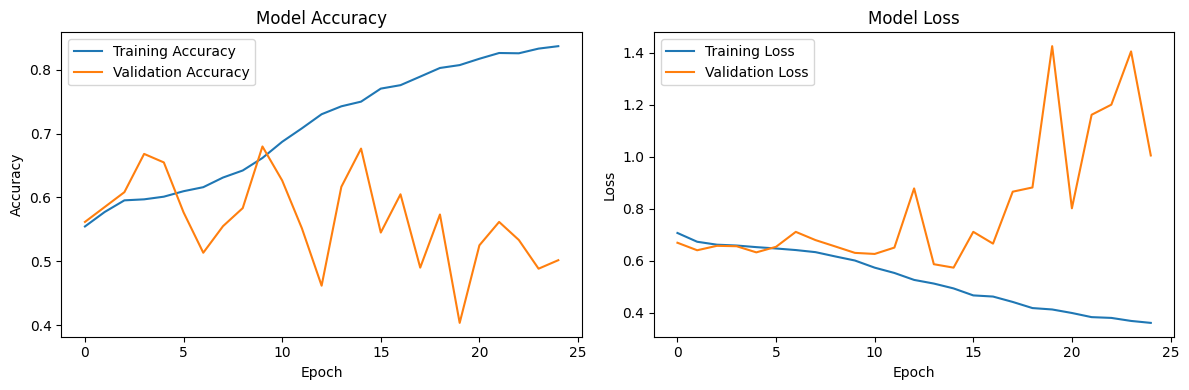

In [14]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()